**Predicting a Tennis Player's Rank**

Section 004

Jonathan Chan (34466219), Erick Jovan Muljadi (96641055), Katie Swangard (13265202), Aurora Wang (47454038)

In [1]:
# Loading in necessary libraries and setting the seed:
set.seed(0004)
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Background Information**

ATP is a worldwide top-tier tennis tour for men organized by the Association of Tennis Professionals.  The question we are trying to ask is: based on three given characteristics of a new player (height, age and hand use), what ATP ranking will he achieve on each of the three different surfaces?  

We will use the dataset "Match Results for Top 500 Players 2017-2019". This data set includes the game statistics from 2017-2019 tournaments. It contains the ranking, results and match statistics of the top 500 players in the ATP, as well as individual characteristics of the winners and losers of each match, such as height, age, and hand use. 



In [2]:
# Reading in our dataset:
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")|>
    rename("ID_num" = 1)
# As the whole dataset would be too large to display, we are only displaying the first 10 rows here.
head(tennis, 10)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID_num,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275
6,2019-M020,Brisbane,Hard,32,A,20181231,294,105453,2,⋯,53,37,13,12,6,9,9,3590,19,1835
7,2019-M020,Brisbane,Hard,32,A,20181231,293,104542,NA,⋯,51,34,11,11,6,11,239,200,77,691
8,2019-M020,Brisbane,Hard,32,A,20181231,292,200282,7,⋯,39,30,3,9,3,6,31,1298,72,715


In [3]:
# Selecting only for rows needed in our data analysis:
tennis_smaller <- tennis|>
    select(ID_num,winner_hand,winner_ht,winner_age, winner_rank,surface, loser_hand,loser_ht, loser_age, loser_rank)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand)) # Mutating ID_num and winner_hand into factor columns.
# Combining winner and loser data into one column:
tennis_pivot <- tennis_smaller |>
    pivot_longer(cols = c("winner_rank", "loser_rank"),
                     names_to = "wol_rank",
                     values_to = "rank") |>
    pivot_longer(cols = c("winner_ht", "loser_ht"),
                     names_to = "wol_height",
                     values_to = "height") |>
    pivot_longer(cols = c("winner_age", "loser_age"),
                     names_to = "wol_age",
                     values_to = "age") |>
    pivot_longer(cols = c("winner_hand", "loser_hand"),
                     names_to = "wol_hand",
                     values_to = "hand")
# Filtering all NA datas, unknown hand and surface
tennis_filtered <- tennis_pivot |>
                    drop_na() |>
                    filter(hand != "U" & surface != "None")
head(tennis_filtered, 10) # Displaying the top 10 columns.

ID_num,surface,wol_rank,rank,wol_height,height,wol_age,age,wol_hand,hand
<fct>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,loser_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,loser_hand,R
0,Hard,loser_rank,16,winner_ht,178,winner_age,29.00479,winner_hand,R
0,Hard,loser_rank,16,winner_ht,178,winner_age,29.00479,loser_hand,R
0,Hard,loser_rank,16,winner_ht,178,loser_age,22.88569,winner_hand,R
0,Hard,loser_rank,16,winner_ht,178,loser_age,22.88569,loser_hand,R
1,Hard,winner_rank,16,loser_ht,188,winner_age,22.88569,winner_hand,R


In [4]:
# Groupping by rank, surface, and hand, then finding mean height and age.
tennis_mean <- tennis_filtered|>
    group_by(rank, surface, hand) |>
    summarize(mean_ht = mean(height, na.rm = TRUE), mean_age = mean(age))
# Displaying only the top 10 columns due to space constraints:
head(tennis_mean, 10)

`summarise()` has grouped output by 'rank', 'surface'. You can override using
the `.groups` argument.


rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.89190
1,Clay,R,186.9524,29.46990
1,Grass,L,185.5833,30.19199
1,Grass,R,186.3857,30.98807
1,Hard,L,186.3253,29.47728
1,Hard,R,187.4488,29.91612
2,Clay,L,184.8364,30.75965
2,Clay,R,185.2842,29.43126
2,Grass,L,185.3600,31.60991


In [5]:
# Splitting our data 75/25 into training and testing data:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [6]:
tennis_training

rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.89190
1,Clay,R,186.9524,29.46990
1,Grass,R,186.3857,30.98807
2,Clay,R,185.2842,29.43126
2,Grass,L,185.3600,31.60991
2,Grass,R,186.7907,32.29683
2,Hard,L,185.4474,30.54575
3,Clay,L,191.0000,29.68671
3,Clay,R,191.0703,27.30874


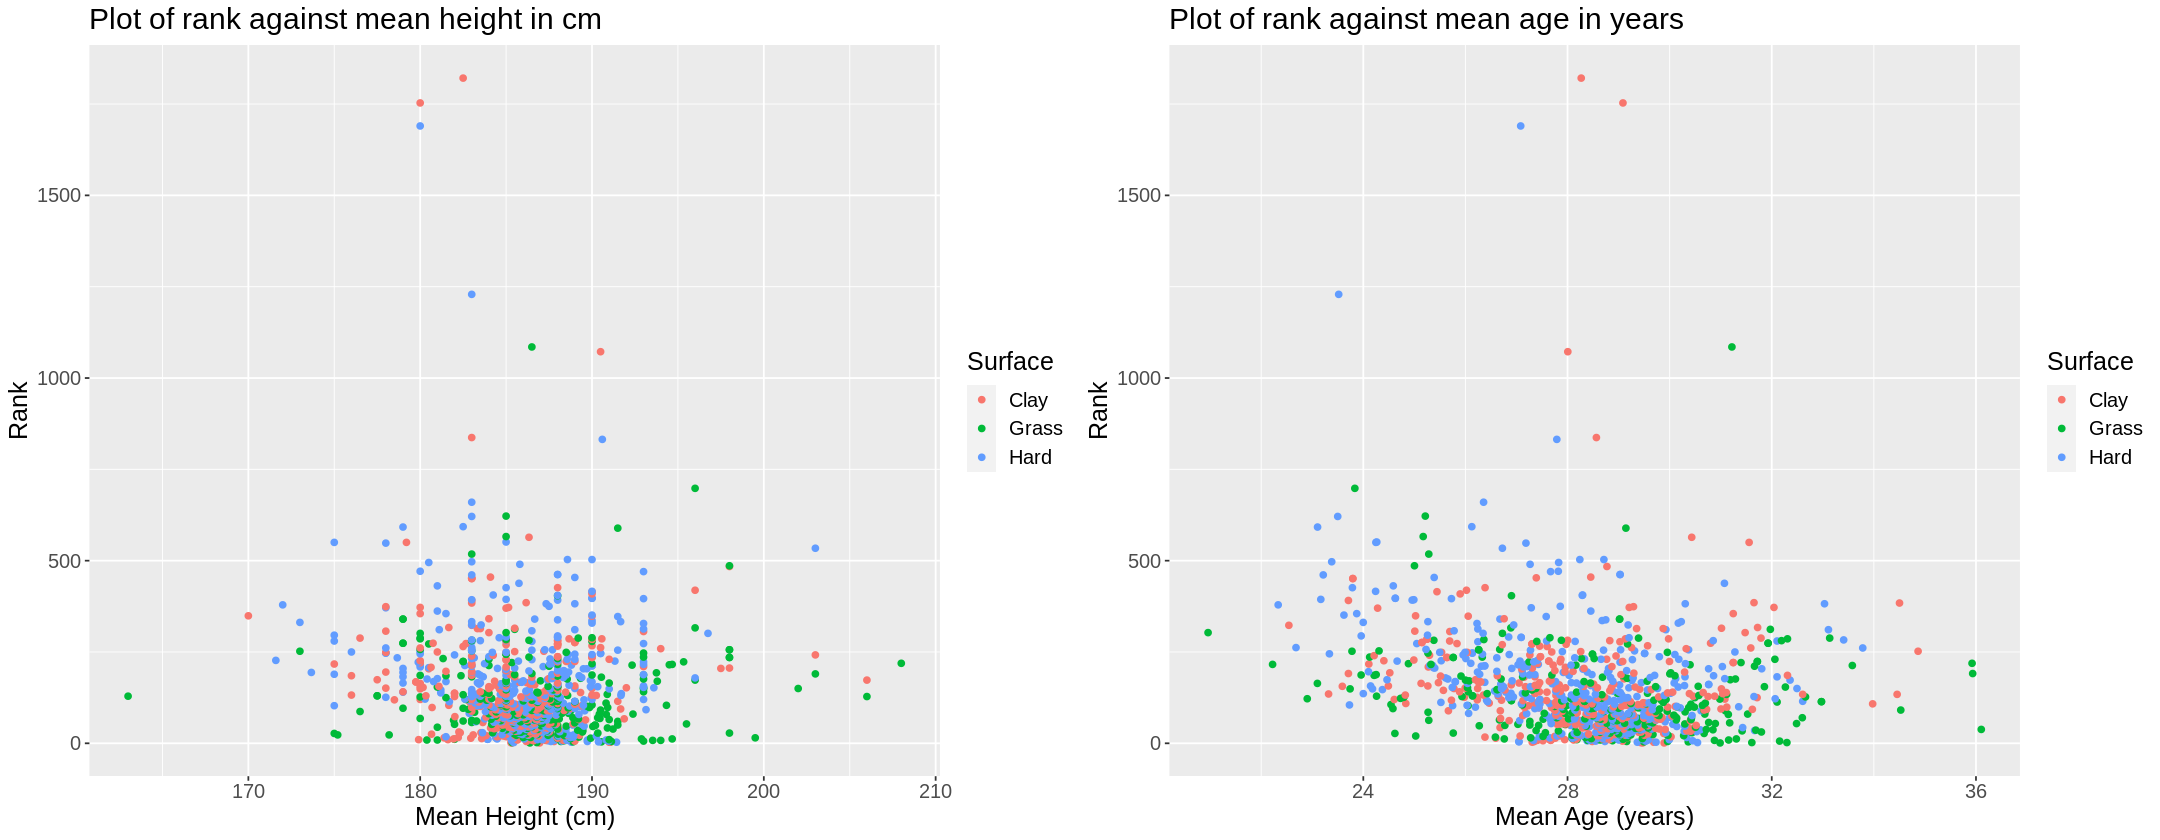

In [7]:
# Plotting rank against mean age:
options(repr.plot.width = 18, repr.plot.height = 7)
rank_vs_age_plot <- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Rank", color = "Surface") +
    ggtitle("Plot of rank against mean age in years")+
    theme(text=element_text(size = 15))

# Plotting height against mean age:
rank_vs_height_plot<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=rank, color = surface))+
    geom_point() +
    labs(x = "Mean Height (cm)", y = "Rank", colour = "Surface") +
    ggtitle("Plot of rank against mean height in cm")+
    theme(text=element_text(size = 15))
# use plot grid
tennis_plots <- plot_grid(rank_vs_height_plot, rank_vs_age_plot)
tennis_plots

In [8]:
# Creating a workflow for further data analysis and prediction using regression:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 

tennis_recipe <- recipe(rank ~ mean_ht + mean_age, data = tennis_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

tennis_workflow <- workflow() |>
                    add_recipe(tennis_recipe) |>
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**Methods**

We set the seed once at the very start of our analysis to ensure what we do will be reproducible.  We will use the variables mentioned above to predict a new player’s rank. After splitting the data into testing and training sets (75/25 split), we will use cross-validation and regression to first find the best value of K for our k-nearest neighbours model. We will then fit our training data to this model and attempt to predict the ranks for our testing data.  Afterwards, we will compare the true ranks to those estimated by our model and determine the model’s accuracy using RMSE. If the RMSE of the training set and the testing set are similar, then our model should be suitable. 

Next, we’ll input a new player’s height, age, and preferred hand and find the new player’s rank using our model. Then, we can make 2 plots with winner_rank vs winner_height and winner_rank vs winner_age with the new player’s data to visualise the data. 



In [16]:
set.seed(0004)
gridvals <- tibble(neighbors = 1:200)
tennis_vfold <- vfold_cv(tennis_training, v=10, strata = rank)
tennis_k_value <- tennis_workflow|>
    tune_grid(resamples = tennis_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "rmse")|>
    filter(mean == min(mean))|>
    pull(neighbors)
    
tennis_k_value

[1] 45

This shows that the optimum value of K to use is 45 so now we will create a new workflow with the correct value of K.

In [25]:
tennis_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = tennis_k_value) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 
tennis_fit <- workflow()|>
    add_recipe(tennis_recipe)|>
    add_model(tennis_spec_best)|>
    fit(data = tennis_training)
tennis_fit

tennis_accuracy <- tennis_fit |>
    predict(tennis_training)|>
    bind_cols(tennis_training)|>
    metrics(truth = rank, estimate = .pred)|>
    
tennis_accuracy

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(45L,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 83.99597
Minimal mean squared error: 21559.86
Best kernel: rectangular
Best k: 45

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,143.5658709
rsq,standard,0.1763491
mae,standard,82.0983850


In [21]:
tennis_summary <- tennis_fit |>
    predict(tennis_testing)|>
    bind_cols(tennis_testing)

ERROR: Error in UseMethod("metrics"): no applicable method for 'metrics' applied to an object of class "workflow"
